In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

In [39]:
# x1 input

df = pd.read_csv('datasets/CNN_parameter_dataset.csv', encoding='utf-8')
int_flow = df.copy()

#preparing the dataset for spliting into features and labels 
int_flow.columns = [col.strip() for col in df.columns]
int_flow.drop(['Sample','Cavity','Pulse width'], axis=1, inplace=True)
int_flow.drop(['Pulse rms','Pulse pkpk'], axis=1, inplace=True)
int_flow['cavity width(mm)'] = int_flow['cavity width(mm)']*1000
#int_flow = sklearn.utils.shuffle(int_flow)
int_flow.head()

,Voltage,Flow rate,Duty cycle,Pulse period,Laser energy,cavity width(mm),cavity depth(µm)
0,25,0.47,20,20,0,2285.0,72.1
1,25,0.47,20,20,0,2199.0,68.2
2,25,0.47,20,20,0,2108.0,67.2
3,25,0.47,20,20,0,2233.0,61.2
4,25,0.47,20,20,0,2046.0,52.2


In [40]:
# x2 input

X2= []
path = r'C:\Users\nikam\Desktop\Academics\Thesis\Internal_flow_experiments\Internal_flow_current_data'   
for folder in (os.listdir(path)):
    dfs = []
    
    for file in (os.listdir(path + '\\'+folder)):
        df = pd.read_csv(path + '\\'+folder + '\\'+file, encoding='unicode_escape', sep='\t' )
        dfs.append(df)
    new_df = pd.concat(dfs)
    for i in range(0,len(new_df),15):
        _df = new_df[i:i+15].copy()
        _df = _df.reset_index(drop=True)
        idx = _df['Pulse rms [A]'].index[_df['Pulse rms [A]'].apply(np.isnan)]
        
        if len(idx)>0: 
            for ii in idx:
                if ii == 0: 
                    replacing_val = _df['Pulse rms [A]'][ii+1]
                elif ii == 14:
                     replacing_val = _df['Pulse rms [A]'][ii-1]   
                else:
                    replacing_val = (_df['Pulse rms [A]'][ii-1]+_df['Pulse rms [A]'][ii+1])/2
                _df.loc[ii,'Pulse rms [A]'] = replacing_val
        X2.append(_df.iloc[:,-2:].to_numpy())        
        
X2 = np.asarray(X2, dtype=np.float16)
X2 =np.expand_dims(X2,axis=1)

In [41]:
#initializing X(features) and y(labels)
X1 = int_flow.drop(['cavity width(mm)','cavity depth(µm)'], axis=1).to_numpy()
#X1 =np.expand_dims(X1,axis=1)
y = int_flow[['cavity depth(µm)']].values

In [42]:
from sklearn import model_selection
X1_train, X1_test,X2_train, X2_test, y_train, y_test = model_selection.train_test_split(X1, X2, y, test_size=0.2, random_state=1)
X1_train_1, X1_dev, X2_train_1, X2_dev, y_train_1, y_dev = model_selection.train_test_split(X1_train, X2_train, y_train, test_size=0.2, random_state=1)

In [17]:
class nncnn(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 10)        
        self.cnn1 = nn.Conv2d(1, 5, (2,2))
        
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x1,x2):
        x1 = F.relu(self.fc1(x1))
        
        x2 = self.cnn1(x2).view(x1.size(0),-1)
        #print(x1.shape, x2.shape)
        x_joined = torch.cat([x1,x2], dim=1)
        #print(x1.shape, x2.shape, x_joined.shape)
        x_joined = F.relu(self.fc2(x_joined))
        x_joined = F.relu(self.fc3(x_joined))
        x_joined = self.fc4(x_joined)

        return x_joined

In [26]:
m = nncnn()
m

nncnn(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (cnn1): Conv2d(1, 5, kernel_size=(2, 2), stride=(1, 1))
  (fc2): Linear(in_features=80, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
#training the neuralnetwork model

X1_train_1 = torch.tensor(X1_train_1, dtype=torch.float64)
X2_train_1 = torch.tensor(X2_train_1, dtype=torch.float64)
y_train_1 = torch.tensor(y_train_1)

X1_dev = torch.tensor(X1_dev, dtype=torch.float64)
X2_dev = torch.tensor(X2_dev, dtype=torch.float64)
y_dev = torch.tensor(y_dev)

In [44]:
from tqdm import tqdm

net = nncnn()

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)

# to track the training loss as the model trains
t_l = []
# to track the validation loss as the model trains
d_l = []

#initialize the early_stopping object
early_stopping = EarlyStopping(patience=50, verbose=True)

for epoch in tqdm(range(10000)):# 10000 full passes over the data        
    net.zero_grad() # sets gradients to 0 before loss calc. You will do this likely every step.
    output = net(X1_train_1.float(), X2_train_1.float()) # pass in the training batch 
    loss = loss_function(output, y_train_1.float()) # calc and grab the loss value
    loss.backward() # apply this loss backwards thru the network's parameters
    optimizer.step() # attempt to optimize weights to account for loss/gradients
    if epoch%5 == 0: 
        with torch.no_grad():
            y_predict = net(X1_dev.float(), X2_dev.float())
            dev_error = loss_function(y_predict, y_dev.float())
            #print(f'train_loss..:{loss.item()} dev_loss..:{dev_error.item()} ')
            t_l.append(loss.item())
            d_l.append(dev_error.item())
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(dev_error, net)
            if early_stopping.early_stop:
                print("Early stopping")
                break  
            #print(loss) # print loss. We hope loss (train_loss..:{loss.item()} a measure of wrong-ness) declines!


  0%|▎                                                                             | 44/10000 [00:00<00:22, 439.62it/s]

Validation loss decreased (inf --> 7759.008301).  Saving model ...
Validation loss decreased (7759.008301 --> 6441.812500).  Saving model ...
Validation loss decreased (6441.812500 --> 1018.658936).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (1018.658936 --> 967.671326).  Saving model ...
Validation loss decreased (967.671326 --> 630.714966).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (630.714966 --> 548.494629).  Saving model ...
Validation loss decreased (548.494629 --> 502.450134).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (502.450134 --> 489.756744).  Saving model ...
Validation loss decreased (489.756744 --> 430.437653).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (430.437653 --> 429.332245).  Saving model ...
Validation loss decreased (429.332245 --> 414.114746).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreas

  2%|█▏                                                                           | 156/10000 [00:00<00:18, 520.15it/s]

Validation loss decreased (391.467438 --> 387.349121).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (387.349121 --> 383.701965).  Saving model ...
Validation loss decreased (383.701965 --> 376.861176).  Saving model ...
Validation loss decreased (376.861176 --> 375.808990).  Saving model ...
Validation loss decreased (375.808990 --> 368.416931).  Saving model ...
Validation loss decreased (368.416931 --> 366.344666).  Saving model ...
Validation loss decreased (366.344666 --> 360.467773).  Saving model ...
Validation loss decreased (360.467773 --> 356.974640).  Saving model ...
Validation loss decreased (356.974640 --> 352.211639).  Saving model ...
Validation loss decreased (352.211639 --> 348.126923).  Saving model ...
Validation loss decreased (348.126923 --> 344.052917).  Saving model ...
Validation loss decreased (344.052917 --> 339.952148).  Saving model ...
Validation loss decreased (339.952148 --> 336.169006).  Saving model ...
Validation loss 

  3%|██                                                                           | 265/10000 [00:00<00:18, 530.69it/s]

Validation loss decreased (314.131104 --> 310.981934).  Saving model ...
Validation loss decreased (310.981934 --> 307.937225).  Saving model ...
Validation loss decreased (307.937225 --> 305.135498).  Saving model ...
Validation loss decreased (305.135498 --> 302.407532).  Saving model ...
Validation loss decreased (302.407532 --> 299.255249).  Saving model ...
Validation loss decreased (299.255249 --> 296.849518).  Saving model ...
Validation loss decreased (296.849518 --> 293.460388).  Saving model ...
Validation loss decreased (293.460388 --> 290.872559).  Saving model ...
Validation loss decreased (290.872559 --> 288.260132).  Saving model ...
Validation loss decreased (288.260132 --> 285.448883).  Saving model ...
Validation loss decreased (285.448883 --> 283.147766).  Saving model ...
Validation loss decreased (283.147766 --> 281.472260).  Saving model ...
Validation loss decreased (281.472260 --> 279.846222).  Saving model ...
Validation loss decreased (279.846222 --> 277.99386

  4%|██▉                                                                          | 375/10000 [00:00<00:17, 535.71it/s]

EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
EarlyStopping counter: 7 out of 50
EarlyStopping counter: 8 out of 50
EarlyStopping counter: 9 out of 50
EarlyStopping counter: 10 out of 50
EarlyStopping counter: 11 out of 50
EarlyStopping counter: 12 out of 50
EarlyStopping counter: 13 out of 50
EarlyStopping counter: 14 out of 50
EarlyStopping counter: 15 out of 50
EarlyStopping counter: 16 out of 50
EarlyStopping counter: 17 out of 50
EarlyStopping counter: 18 out of 50
EarlyStopping counter: 19 out of 50
EarlyStopping counter: 20 out of 50
EarlyStopping counter: 21 out of 50
EarlyStopping counter: 22 out of 50
EarlyStopping counter: 23 out of 50
EarlyStopping counter: 24 out of 50


  5%|███▋                                                                         | 486/10000 [00:00<00:17, 539.22it/s]

EarlyStopping counter: 25 out of 50
EarlyStopping counter: 26 out of 50
EarlyStopping counter: 27 out of 50
EarlyStopping counter: 28 out of 50
EarlyStopping counter: 29 out of 50
EarlyStopping counter: 30 out of 50
EarlyStopping counter: 31 out of 50
EarlyStopping counter: 32 out of 50
EarlyStopping counter: 33 out of 50
EarlyStopping counter: 34 out of 50
EarlyStopping counter: 35 out of 50
EarlyStopping counter: 36 out of 50
EarlyStopping counter: 37 out of 50
EarlyStopping counter: 38 out of 50
EarlyStopping counter: 39 out of 50
EarlyStopping counter: 40 out of 50
EarlyStopping counter: 41 out of 50
EarlyStopping counter: 42 out of 50
EarlyStopping counter: 43 out of 50
EarlyStopping counter: 44 out of 50
EarlyStopping counter: 45 out of 50


  5%|████▏                                                                        | 540/10000 [00:01<00:17, 528.82it/s]

EarlyStopping counter: 46 out of 50
EarlyStopping counter: 47 out of 50
EarlyStopping counter: 48 out of 50
EarlyStopping counter: 49 out of 50
EarlyStopping counter: 50 out of 50
Early stopping


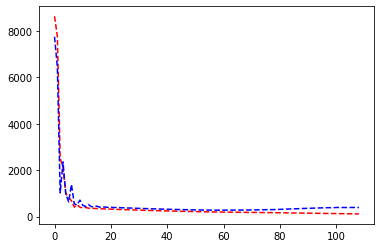

In [45]:
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
#t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t_l,'r--', d_l,'b--')
plt.show()

In [46]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

X1_test = torch.tensor(X1_test)
X2_test = torch.tensor(X2_test)
y_test = torch.tensor(y_test)

y_predict_1 = net(X1_test.float(), X2_test.float())
error = loss_function(y_predict_1, y_test.float())

print(error.item())
for a in (list(zip(y_test,y_predict_1))):
    print(a)
    
print(r2_score(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

print('MAPE for depth: ', mean_absolute_percentage_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

print('MSE for depth: ', mean_squared_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

523.2335205078125
(tensor([85.2000], dtype=torch.float64), tensor([70.6991], grad_fn=<UnbindBackward0>))
(tensor([67.4000], dtype=torch.float64), tensor([99.9016], grad_fn=<UnbindBackward0>))
(tensor([76.], dtype=torch.float64), tensor([142.0432], grad_fn=<UnbindBackward0>))
(tensor([103.5000], dtype=torch.float64), tensor([115.8007], grad_fn=<UnbindBackward0>))
(tensor([77.5000], dtype=torch.float64), tensor([102.5497], grad_fn=<UnbindBackward0>))
(tensor([138.], dtype=torch.float64), tensor([122.2040], grad_fn=<UnbindBackward0>))
(tensor([65.], dtype=torch.float64), tensor([105.2962], grad_fn=<UnbindBackward0>))
(tensor([81.1000], dtype=torch.float64), tensor([101.2183], grad_fn=<UnbindBackward0>))
(tensor([77.3000], dtype=torch.float64), tensor([87.5282], grad_fn=<UnbindBackward0>))
(tensor([72.9000], dtype=torch.float64), tensor([80.6645], grad_fn=<UnbindBackward0>))
(tensor([96.5000], dtype=torch.float64), tensor([88.5833], grad_fn=<UnbindBackward0>))
(tensor([89.9000], dtype=torc

In [9]:
import os, pathlib, random

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



class EarlyStopping:
	"""Early stops the training if validation loss doesn't improve after a given patience."""
	def __init__(self, patience, verbose=False, delta=0, save_path='checkpoint.pt'):
		"""
		Args:
			patience (int): How long to wait after last time validation loss improved.
							Default: 7
			verbose (bool): If True, prints a message for each validation loss improvement.
							Default: False
			delta (float): Minimum change in the monitored quantity to qualify as an improvement.
							Default: 0
		"""
		self.patience = patience
		self.verbose = verbose
		self.counter = 0
		self.best_score = None
		self.early_stop = False
		self.val_loss_min = np.inf
		self.delta = delta
		self.save_path = save_path
		os.makedirs(pathlib.Path(self.save_path).parent, exist_ok=True)

	def __call__(self, val_loss, model):

		score = -val_loss

		if self.best_score is None:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
		elif score < self.best_score - self.delta:
			self.counter += 1
			print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
			if self.counter >= self.patience:
				self.early_stop = True
		else:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
			self.counter = 0

	def save_checkpoint(self, val_loss, model):
		"""Saves model when validation loss decrease."""
		if self.verbose:
			print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
		torch.save(model.state_dict(), self.save_path)
		self.val_loss_min = val_loss